## 1 Реализация протокола Диффи-Хеллмана

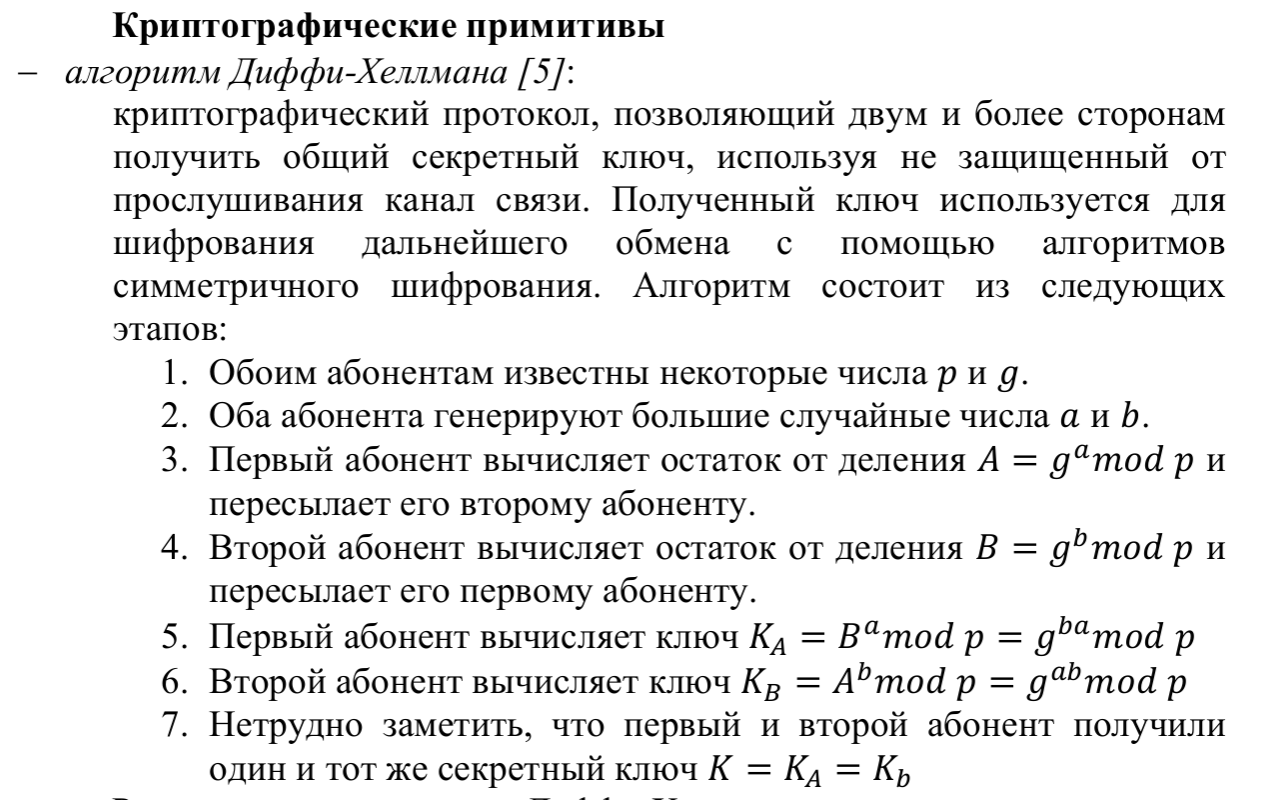


шаг 1. Подключим библиотеки

In [ ]:
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.asymmetric import dh
from cryptography.hazmat.primitives.kdf.hkdf import HKDF

Пояснение:

шаг 2. Создадим объект для генерации ключей

In [ ]:
parameters = dh.generate_parameters(generator=2, key_size=2048)

шаг 3. Получим закрытый ключ

In [ ]:
private_key = parameters.generate_private_key()
public_key = private_key.public_key()

шаг 4. Получим параметры, которые были сгенерированы

In [ ]:
dh_numbers = parameters.parameter_numbers()

шаг 5. Передадим параметры другой стороне и сгенерируем объект для генерации ключей

In [ ]:
peer_parameters = dh.DHParameterNumbers(dh_numbers.p, dh_numbers.g).parameters()

шаг 6. Сгенерируем закрытый ключ на другой стороне

In [ ]:
peer_private_key = peer_parameters.generate_private_key()

шаг 7. Получим публичный ключ другой стороны

In [ ]:
peer_public_key = peer_private_key.public_key()

шаг 8. На основе публичного ключа другой стороны создаем общий ключ

In [ ]:
shared_key = private_key.exchange(peer_public_key)

шаг 9. Аналогично получаем публичный ключ на другой стороне

In [ ]:
peer_shared_key = peer_private_key.exchange(public_key)

шаг 10. Преобразуем полученный общий ключ в ключ длиной 256-бит с помощью KDF KDF - функция, формирующая один или несколько секретных ключей на основе секретного значения (главный ключ, пароль или парольная фраза) с помощью псевдослучайной функции. Создаем объект HKDF, с помощью которого создадим ключ для симметричного шифрования

In [ ]:
hkdf_obj = HKDF(
  algorithm=hashes.SHA256(),
  length=32,
  salt=None,
  info=b"",
)
peer_hkdf_obj = HKDF(
  algorithm=hashes.SHA256(),
  length=32,
  salt=None,
  info=b"",
)

шаг 11. Получим ключ длиной 256-бит

In [ ]:
derived_key = hkdf_obj.derive(shared_key)

шаг 12. Получим ключ длиной 256-бит на другой стороны

In [ ]:
peer_derived_key = peer_hkdf_obj.derive(peer_shared_key)

шаг 13. Сравним полученные ключи

In [ ]:
print(f"Are keys equal: {derived_key == peer_derived_key}")

Are keys equal: True


## Приложение 2 Реализация алгоритма AES

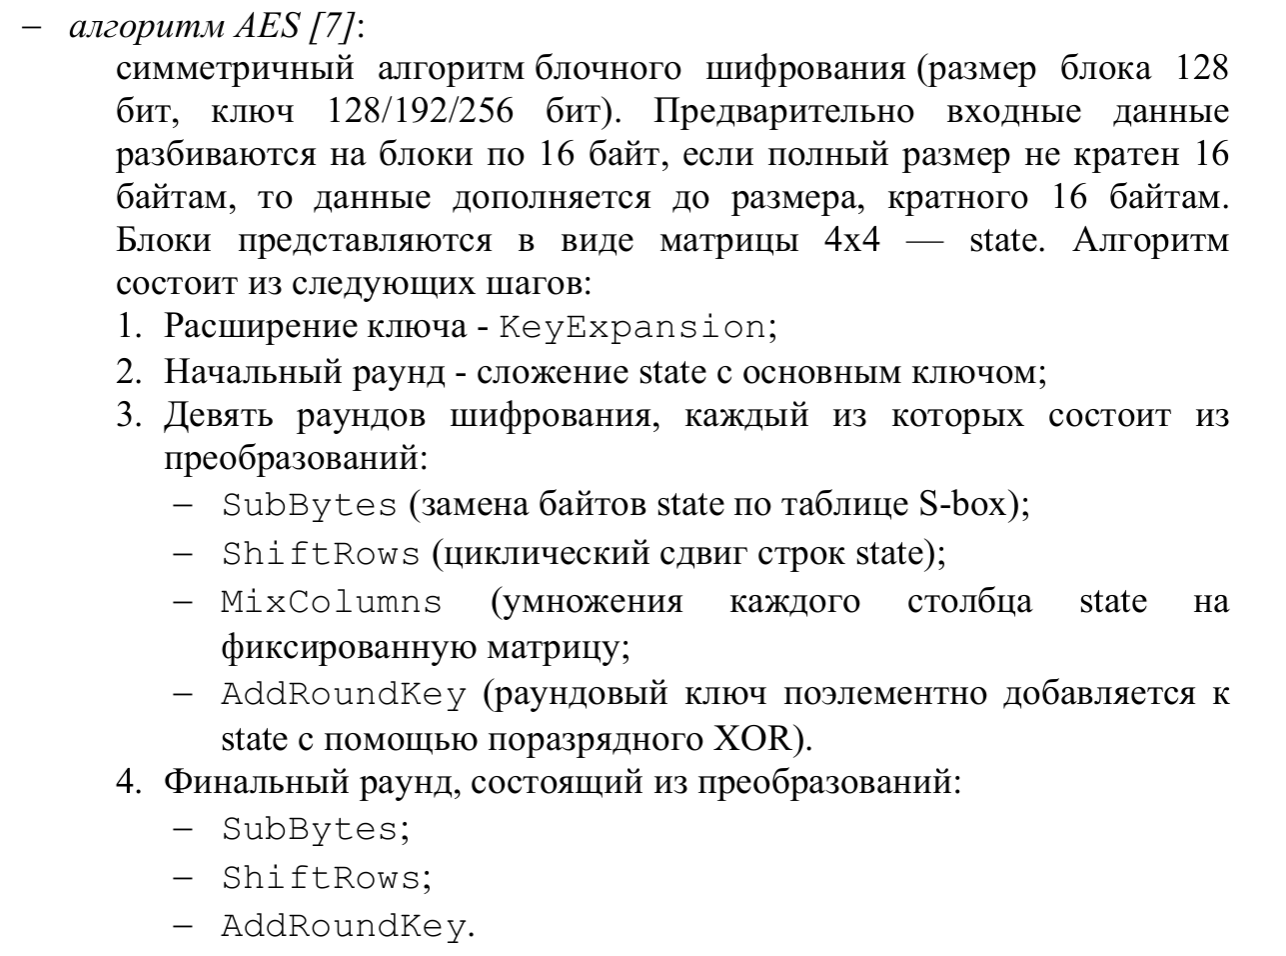



шаг 1. Подключим библиотеки

In [ ]:
import os
from cryptography.hazmat.primitives import padding
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes

шаг 2. Создадим функцию для реализации алгоритма

In [ ]:
def check_cipher_suite(cipher_suite, padding_algorithm):
  # Получим объекты для шифрования и паддинга
  encryptor = cipher_suite.encryptor()
  padder = padding_algorithm.padder()
  # Текст, который будем шифровать
  plain_text = b"ITMO"
  # Сделаем паддинг текста
  padded_plain_text = padder.update(plain_text) + padder.finalize()
  print(f"Padded text: {padded_plain_text}")
  # Зашифруем текст
  cipher_text = encryptor.update(padded_plain_text) + encryptor.finalize()
  print(f"Cipher text: {cipher_text}")
  # Получим объекты для дешифрования и анпаддинга
  decryptor = cipher_suite.decryptor()
  unpadder = padding_algorithm.unpadder()
  # Получим расшифрованный текст, к которому применен паддинг
  padded_plain_text = decryptor.update(cipher_text) + decryptor.finalize()
  print(f"Decrypted text: {padded_plain_text}")
  # Получим текст, который был зашифрован
  plain_text = unpadder.update(padded_plain_text) + unpadder.finalize()
  print(f"Unpadded text: {plain_text}")

шаг 4. Сгенерируем ключ и вектор инициализации

In [ ]:
key = os.urandom(16) # 128-битовый ключ
iv = os.urandom(16) # вектор инициализации

шаг 5. Создадим объект с набором инструментов для работы с AES в режиме CBC

In [ ]:
cipher_suite = Cipher(algorithms.AES(key), modes.CBC(iv))

шаг 6. Для паддинга будем использовать PKCS7. Размер блока шифрования - 128 бит (AES)

In [ ]:
check_cipher_suite(cipher_suite, padding.PKCS7(128))
print()
key = os.urandom(16) # 128-битовый ключ

Padded text: b'ITMO\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c'
Cipher text: b'\xfe\x10\x15\x10\xd2\xca\x033\x8bG\x9e\xba\xca;\xce\xb1'
Decrypted text: b'ITMO\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c'
Unpadded text: b'ITMO'



шаг 7. Создадим объект с набором инструментов для работы с AES в режиме ECB

In [ ]:
cipher_suite = Cipher(algorithms.AES(key), modes.ECB())

шаг 8. Для паддинга будем использовать PKCS7. Размер блока шифрования - 128 бит (AES)

In [ ]:
check_cipher_suite(cipher_suite, padding.PKCS7(128))
print()
key = os.urandom(16) # 128-битовый ключ

Padded text: b'ITMO\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c'
Cipher text: b'\x83\r\x18(\xedS\x83NQ{\x9f\x8f\xfek7\x13'
Decrypted text: b'ITMO\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c'
Unpadded text: b'ITMO'



шаг 9. Создадим объект с набором инструментов для работы с AES в режиме ECB

In [ ]:
cipher_suite = Cipher(algorithms.AES(key), modes.ECB())

шаг 10. Для паддинга будем использовать ANSIX923. Размер блока шифрования - 128 бит (AES)

In [ ]:
check_cipher_suite(cipher_suite, padding.ANSIX923(128))
print()
key = os.urandom(24) # 192-битовый ключ

Padded text: b'ITMO\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0c'
Cipher text: b'\xbb\xdf\x85\n\xe6Eh\xeb\xe8\xd2(y\xe2\xb8\x8aa'
Decrypted text: b'ITMO\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0c'
Unpadded text: b'ITMO'



шаг 11. Создадим объект с набором инструментов для работы с Camellia в режиме ECB

In [ ]:
cipher_suite = Cipher(algorithms.Camellia(key), modes.ECB())

шаг 12. Для паддинга будем использовать PKCS7. Размер блока шифрования - 128 бит (Camellia)

In [ ]:
check_cipher_suite(cipher_suite, padding.PKCS7(128))
print()

Padded text: b'ITMO\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c'
Cipher text: b'\x8a:\xed7\x0f\x8fN\x96\x8f\xed\x07.\xee\xc9X\x92'
Decrypted text: b'ITMO\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c'
Unpadded text: b'ITMO'



Задача 1
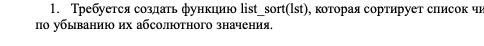

Задача 2 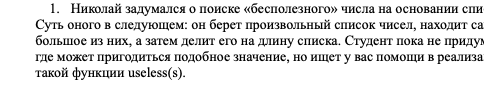